# Sinusoidal regression
In this notebook we show how to use Fortuna to obtain calibrated uncertainty estimates of predictions in a sinusoidal regression task.

In [1]:
!pip install -q aws-fortuna

### Generate the data
We first generate the data. These are couple of input and target variables following a sinusoidal relation perturbed by noise.

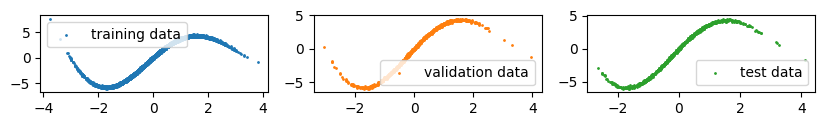

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def make_sinusoidal(n_data: int, noise: float = 0.1, seed: int = 0):
    np.random.seed(seed)
    w = np.arange(30)[:, None] / 30
    b = 2 * np.pi * np.arange(30)[:, None] / 30

    x = np.random.normal(size=(n_data,))
    y = np.cos(w * x + b).sum(0) + noise * np.random.normal(size=(n_data,))
    return x[:, None], y[:, None]
train_data = make_sinusoidal(n_data=10000, seed=0)
val_data = make_sinusoidal(n_data=1000, seed=1)
test_data = make_sinusoidal(n_data=1000, seed=2)

fig, axes = plt.subplots(1, 3, figsize=(10, 1))
axes[0].scatter(*train_data, s=1, label="training data", c="C0"); axes[0].legend()
axes[1].scatter(*val_data, s=1, label="validation data", c="C1"); axes[1].legend()
axes[2].scatter(*test_data, s=1, label="test data", c="C2"); axes[2].legend()

### Convert data to a compatible data loader
Fortuna helps you converting tuple of arrays into a compatible data loader.

In [11]:
from fortuna.data import DataLoader
train_data_loader = DataLoader.from_array_data(train_data, batch_size=128, shuffle=True, prefetch=True)
val_data_loader = DataLoader.from_array_data(val_data, batch_size=128, prefetch=True)
test_data_loader = DataLoader.from_array_data(test_data, batch_size=128, prefetch=True)

### Build a probabilistic regressor
Let us build a probabilistic regressor. This is an interface object containing several attributes that you can configure, i.e. `model`, `likelihood_log_variance_model`, `prior`, `posterior_approximator`, `output_calibrator`. In this example, we use an MLP model for both mean and log-variance of the likelihood, a Deep Ensemble posterior approximator, and the default temperature scaling output calibrator.

In [4]:
from fortuna.prob_model import ProbRegressor
from fortuna.model import MLP
from fortuna.prob_model.posterior import DeepEnsemblePosteriorApproximator
import flax.linen as nn
output_dim = 1
prob_model = ProbRegressor(
    model=MLP(output_dim=output_dim, activations=(nn.tanh, nn.tanh)),
    likelihood_log_variance_model=MLP(output_dim=output_dim),
    posterior_approximator=DeepEnsemblePosteriorApproximator()
)

### Train the probabilistic model: posterior fitting and calibration
We can now train the probabilistic model. This includes fitting the posterior distribution and calibrating the probabilistic model.

In [5]:
from fortuna.prob_model.fit_config import FitConfig, FitMonitor
from fortuna.metric.regression import rmse
status = prob_model.train(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    calib_data_loader=val_data_loader,
    fit_config=FitConfig(monitor=FitMonitor(metrics=(rmse,)))
)

Epoch: 39 | loss: -3988.06812 | rmse: 0.72758:  37%|████████████████████████████████████████████▊                                                                            | 37/100 [00:03<00:04, 13.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch: 92 | loss: -5917.71045 | rmse: 0.36148:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 91/100 [00:07<00:00, 14.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limi

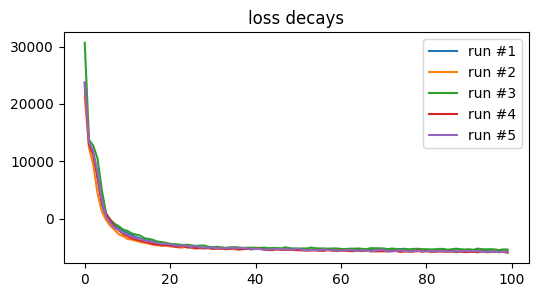

In [6]:
plt.figure(figsize=(6,3))
for i, s in enumerate(status["fit_status"]):
    plt.plot(s["loss"], label=f"run #{i+1}")
plt.legend()
plt.title("loss decays", fontsize=12);

### Estimate predictive statistics
We can now compute some predictive statistics by invoking the `predictive` attribute of the probabilistic regressor, and the method of interest. Most predictive statistics, e.g. mean or variance, require a loader of input data points. You can easily get this from the data loader calling its method `to_inputs_loader`.

In [7]:
test_log_probs = prob_model.predictive.log_prob(data_loader=test_data_loader)
test_inputs_loader = test_data_loader.to_inputs_loader()
test_means = prob_model.predictive.mean(inputs_loader=test_inputs_loader)
test_aleatoric_variances = prob_model.predictive.aleatoric_variance(inputs_loader=test_inputs_loader)
test_epistemic_variances = prob_model.predictive.epistemic_variance(inputs_loader=test_inputs_loader)
test_variances = prob_model.predictive.variance(inputs_loader=test_inputs_loader, aleatoric_variances=test_aleatoric_variances, epistemic_variances=test_epistemic_variances)
test_stds = prob_model.predictive.std(inputs_loader=test_inputs_loader, variances=test_variances)
test_cred_intervals = prob_model.predictive.credible_interval(inputs_loader=test_inputs_loader)

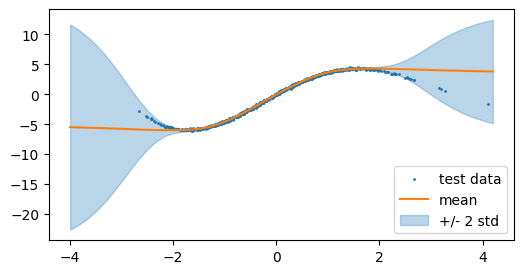

In [8]:
from fortuna.data import InputsLoader
mesh = np.linspace(-4, 4.2)
mesh_loader = InputsLoader.from_array_inputs(mesh)
mesh_mean = prob_model.predictive.mean(mesh_loader)
mesh_std = prob_model.predictive.std(mesh_loader)
plt.figure(figsize=(6, 3))
plt.scatter(*test_data, s=1, color="C0", label="test data")
plt.plot(mesh, mesh_mean, color="C1", label="mean")
plt.fill_between(mesh, (mesh_mean - 2 * mesh_std).squeeze(1), (mesh_mean + 2 * mesh_std).squeeze(1), alpha=0.3, color="C0", label=f"+/- {2} std")
plt.legend(loc="lower right");

### Compute metrics
Given the predictive statistics, we compute metrics to assess how well the probabilistic model fit the data, and how calibrated are uncertainty estimates.

In [9]:
from fortuna.metric.regression import root_mean_squared_error, prediction_interval_coverage_probability
test_targets = test_data_loader.to_array_targets()
rmse = root_mean_squared_error(preds=test_means, targets=test_targets)
cred_picp = prediction_interval_coverage_probability(lower_bounds=test_cred_intervals[:, 0], upper_bounds=test_cred_intervals[:, 1], targets=test_targets)
print(f"Test RMSE: {rmse}")
print(f"PICP for 95% credible intervals of test inputs: {cred_picp}")

Test RMSE: 0.2836633324623108
PICP for 95% credible intervals of test inputs: 0.9140000343322754


### Conformal intervals
The PICP metric shows that the 95% credible intervals above are not perfectly calibrated. Conformal prediction methods provide a way to correct them and improve their calibration.

In [10]:
from fortuna.conformal.regression import QuantileConformalRegressor
val_inputs_loader = val_data_loader.to_inputs_loader()
val_cred_intervals = prob_model.predictive.credible_interval(inputs_loader=val_inputs_loader)
test_conformal_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=val_cred_intervals[:, 0], val_upper_bounds=val_cred_intervals[:, 1],
    test_lower_bounds=test_cred_intervals[:, 0], test_upper_bounds=test_cred_intervals[:, 1],
    val_targets=val_data_loader.to_array_targets(), error=0.05
)
conformal_picp = prediction_interval_coverage_probability(lower_bounds=test_conformal_intervals[:, 0], upper_bounds=test_conformal_intervals[:, 1], targets=test_targets)
print(f"PICP for 95% conformal intervals of test inputs: {conformal_picp}")

PICP for 95% conformal intervals of test inputs: 0.9530000686645508


Another possibility is to get conformal interval starting from a one-dimensinal uncertainty statistic, e.g. the standard deviation.

In [ ]:
from fortuna.conformal.regression import OneDimensionalUncertaintyConformalRegressor
val_means = prob_model.predictive.mean(inputs_loader=val_inputs_loader)
val_stds = prob_model.predictive.std(inputs_loader=val_inputs_loader)

test_conformal_intervals2 = OneDimensionalUncertaintyConformalRegressor().conformal_interval(
    val_preds=val_means, val_uncertainties=val_stds, test_preds=test_means, test_uncertainties=test_stds, 
    val_targets=val_data_loader.to_array_targets(), error=0.05
)
conformal_picp2 = prediction_interval_coverage_probability(lower_bounds=test_conformal_intervals2[:, 0], upper_bounds=test_conformal_intervals2[:, 1], targets=test_targets)
print(f"PICP for 95% conformal intervals of test inputs: {conformal_picp2}")

### What if we have model outputs to start from?

If you have already trained a model and obtained model outputs, you can still use Fortuna to calibrate them, and estimate uncertainty. For educational purposes only, let us take the concatenation of predictive mean and log-variance as model outputs, and pretend these were generated with some other framework. Furthermore, we store arrays of validation and test target variables, and assume these were also given.

In [ ]:
import numpy as np
calib_outputs = np.concatenate((val_means, np.log(prob_model.predictive.variance(val_inputs_loader))), axis=-1)
test_outputs = np.concatenate((test_means, np.log(test_variances)), axis=-1)

calib_targets = val_data_loader.to_array_targets()
test_targets = test_data_loader.to_array_targets()

We now invoke a calibration classifier, with default temperature scaling output calibrator, and calibrate the model outputs.

In [ ]:
from fortuna.calib_model.regression import CalibRegressor
calib_model = CalibRegressor()
calib_status = calib_model.calibrate(calib_outputs=calib_outputs, calib_targets=calib_targets)


Similarly as above, we can now compute predictive statistics.

In [ ]:
test_log_probs = calib_model.predictive.log_prob(outputs=test_outputs, targets=test_targets)
test_means = calib_model.predictive.mean(outputs=test_outputs)
test_variances = calib_model.predictive.variance(outputs=test_outputs)
test_stds = calib_model.predictive.std(outputs=test_outputs, variances=test_variances)
test_cred_intervals = calib_model.predictive.credible_interval(outputs=test_outputs)

Then one can compute metrics and conformal intervals, exactly as done above.